# **PRISM ALGORITHM**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [27]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:

    # What does the rule mean: kombinasi kondisi fitur yang menjelaskan pola khas pada data.
    # What class does it represent: satu kelas target tertentu yang memenuhi kondisi rule.
    # How strong or specific is the rule: diukur dari nilai support (jumlah data yang cocok) dan coverage (proporsi kelas yang tercakup).

    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    # What does the rule mean: mencari kombinasi fitur dan nilai (term) yang paling kuat mendukung kelas target.
    # What class does it represent: kelas target (target_val) yang sedang dicari polanya.
    # How strong or specific is the rule: semakin tinggi probabilitas (prob) dan frekuensi (freq), semakin spesifik dan kuat rule-nya.

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term
    
    # What does the rule mean: mencari kombinasi term terbaik (fitur-nilai) yang menghasilkan aturan baru dengan probabilitas tertinggi terhadap target.
    # What class does it represent: kelas target (target_val) yang sedang dianalisis untuk dibuatkan rule-nya.
    # How strong or specific is the rule: kekuatan rule ditentukan oleh probabilitas tertinggi (max_prob) dan hanya diterima jika melebihi ambang batas min_prob.

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df
    
    # What does the rule mean: membentuk seluruh kumpulan aturan (rules) untuk satu nilai target tertentu berdasarkan kombinasi fitur yang paling mendukung nilai tersebut.
    # What class does it represent: nilai spesifik dari kolom target (target_val) yang sedang dicari aturan klasifikasinya.
    # How strong or specific is the rule: diukur dari persentase dukungan (support) dan cakupan (coverage) terhadap total dan sisa data; semakin tinggi nilainya, semakin kuat dan relevan rule-nya.

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    # What does the rule mean: menampilkan semua aturan (rules) yang sudah dihasilkan untuk setiap nilai target agar mudah dibaca dan dianalisis.
    # What class does it represent: setiap nilai unik dari kolom target (target_val) ditampilkan dengan daftar rule yang sesuai.
    # How strong or specific is the rule: kekuatan rule terlihat dari informasi support dan coverage yang ditampilkan (jika display_stats=True).

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    # What does the rule mean: menghasilkan dan menampilkan seluruh aturan (rules) PRISM berdasarkan pola yang muncul dari setiap nilai target dalam dataset.
    # What class does it represent: setiap nilai unik dalam kolom target (target_val) dianggap sebagai satu kelas, dan fungsi ini mencari rule yang menggambarkan masing-masing kelas tersebut.
    # How strong or specific is the rule: kekuatan rule tergantung pada probabilitas minimum (min_prob) dan jumlah minimum data yang tercakup (min_coverage); semakin tinggi nilainya, semakin spesifik dan kuat rule yang dihasilkan.

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict
    
    # What does the rule mean: fungsi ini memprediksi kelas (target value) dari data baru berdasarkan rule PRISM yang telah dibentuk sebelumnya.
    # What class does it represent: setiap baris data akan diklasifikasikan ke dalam salah satu kelas target yang sesuai dengan rule yang terpenuhi.
    # How strong or specific is the rule: prediksi dianggap kuat jika rule yang cocok memiliki semua kondisi (term) terpenuhi secara lengkap; jika tidak ada rule yang cocok, nilai default atau “NO PREDICTION” diberikan.

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    # What does the rule mean: fungsi ini menampilkan atau mengembalikan rentang (range) dari setiap bin yang dibuat saat proses binning fitur numerik.
    # What class does it represent: tidak merepresentasikan kelas tertentu, hanya informasi pendukung untuk interpretasi fitur numerik yang dibagi menjadi kategori (Low, Med, High, dll).
    # How strong or specific is the rule: rule ini bersifat informatif dan tidak memiliki kekuatan klasifikasi, tapi penting untuk memahami batas tiap bin yang digunakan dalam pembentukan rule.

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# EDA


In [28]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv "
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [29]:
# datanya bersih, tidak ada missing value

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [30]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


1. alcohol → Rata-rata kadar alkohol 13.0, dengan rentang 11.03–14.83, yang berarti sebagian besar wine punya kadar alkohol sedang, hanya sedikit yang sangat tinggi.
2. malic_acid → Nilai bervariasi cukup lebar, yaitu 0.74–5.8, menandakan tingkat keasaman antar wine sangat berbeda.
3. ash → Relatif stabil (rata-rata 2.37, std kecil), berarti kandungan abu dalam wine tidak banyak berbeda antar sampel.
4. alcalinity_of_ash → Rentang cukup besar (10.6–30.0), menunjukkan variasi tingkat alkalinitas tinggi antar tipe wine.
5. magnesium → Rata-rata ~100, dengan maksimum 162, menunjukkan sebagian besar wine berada di kisaran sedang untuk mineral magnesium.
6. total_phenols → Rata-rata 2.3, menunjukkan kadar fenol cukup merata; nilai tinggi berkontribusi terhadap rasa dan kualitas wine.
7. flavanoids → Nilai rata-rata 2.0, tapi dengan variasi besar (maks 5.08), artinya beberapa wine kaya flavonoid → lebih kompleks rasanya.
8. nonflavanoid_phenols → Stabil (mean 0.36, std kecil), artinya kontribusi komponen non-flavonoid hampir seragam.
9. proanthocyanins → Rata-rata 1.59, variasinya cukup tinggi; senyawa ini memengaruhi warna dan kepahitan wine.
10. color_intensity → Rentang 1.28–13.00, variasi paling lebar; warna wine sangat berbeda antar kelas (indikator kuat tipe wine).
11. hue → Rata-rata 0.96, variasi kecil; menunjukkan perbedaan hue antar sampel tidak terlalu besar.
12. od280/od315_of_diluted_wines → Rata-rata 2.61, menggambarkan tingkat kejernihan atau kualitas optik wine, dengan variasi sedang.
13. proline → Variasi sangat besar (278–1680), artinya kandungan asam amino ini sangat berbeda antar wine dan bisa jadi ciri pembeda utama.
14. Y → Memiliki rentang 0–2 dan terlihat seimbang dari kuartilnya 0–2, yang berarti ketiga tipenya relatif punya jumlah sampel yang mirip, bagus untuk klasifikasi.

In [31]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


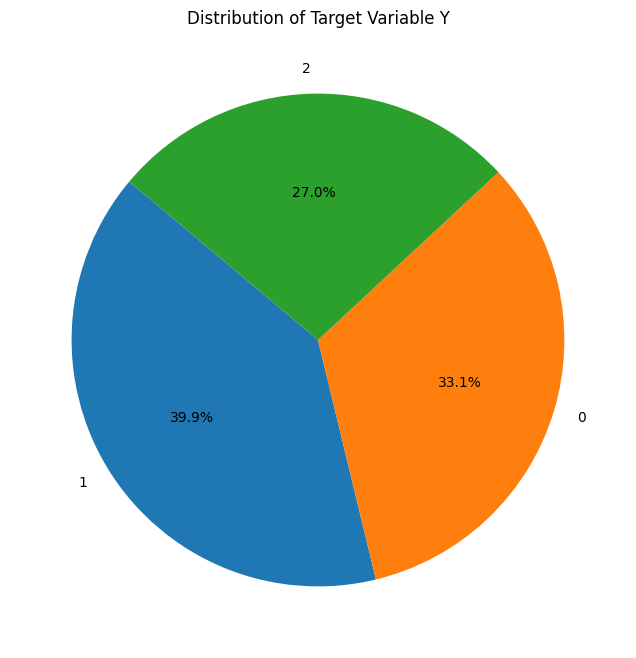

In [32]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

Diagram pie menunjukkan distribusi target variabel Y ke dalam tiga kelas utama, yaitu kelas 1 sebesar 39,9%, kelas 0 sebesar 33,1%, dan kelas 2 sebesar 27,0%. Proporsi ini memperlihatkan bahwa data relatif seimbang, meskipun kelas 1 memiliki jumlah yang paling besar sehingga berpotensi menjadi kelas dominan dalam proses klasifikasi. Perbedaan proporsi antar kelas yang tidak terlalu jauh menandakan bahwa model pembelajaran yang dibangun nantinya tidak akan terlalu bias terhadap satu kelas tertentu, namun tetap perlu memperhatikan keseimbangan saat melakukan evaluasi performa model.

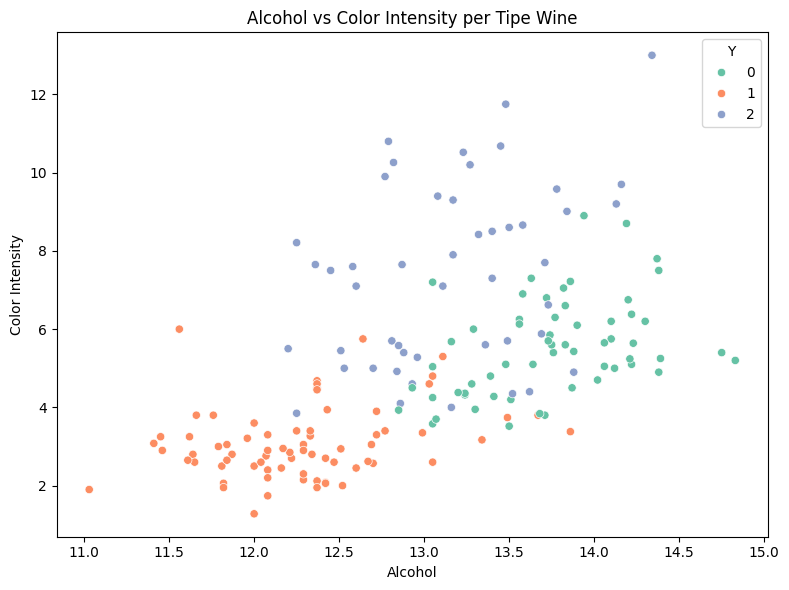

In [33]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='alcohol', y='color_intensity', hue='Y', palette='Set2')
plt.title('Alcohol vs Color Intensity per Tipe Wine')
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.tight_layout()
plt.show()

Scatter plot tersebut menunjukkan hubungan antara kadar alkohol dan intensitas warna pada tiga tipe wine yang direpresentasikan oleh variabel Y (0, 1, 2). Semakin tinggi kadar alkohol, semakin tinggi pula intensitas warna wine. Wine dengan label Y = 1 cenderung memiliki kadar alkohol rendah dan warna lebih pucat, sedangkan Y = 2 umumnya memiliki alkohol dan intensitas warna yang lebih tinggi. Pola ini menunjukkan bahwa kadar alkohol dapat menjadi indikator kuat dalam membedakan jenis wine berdasarkan karakteristik visualnya.

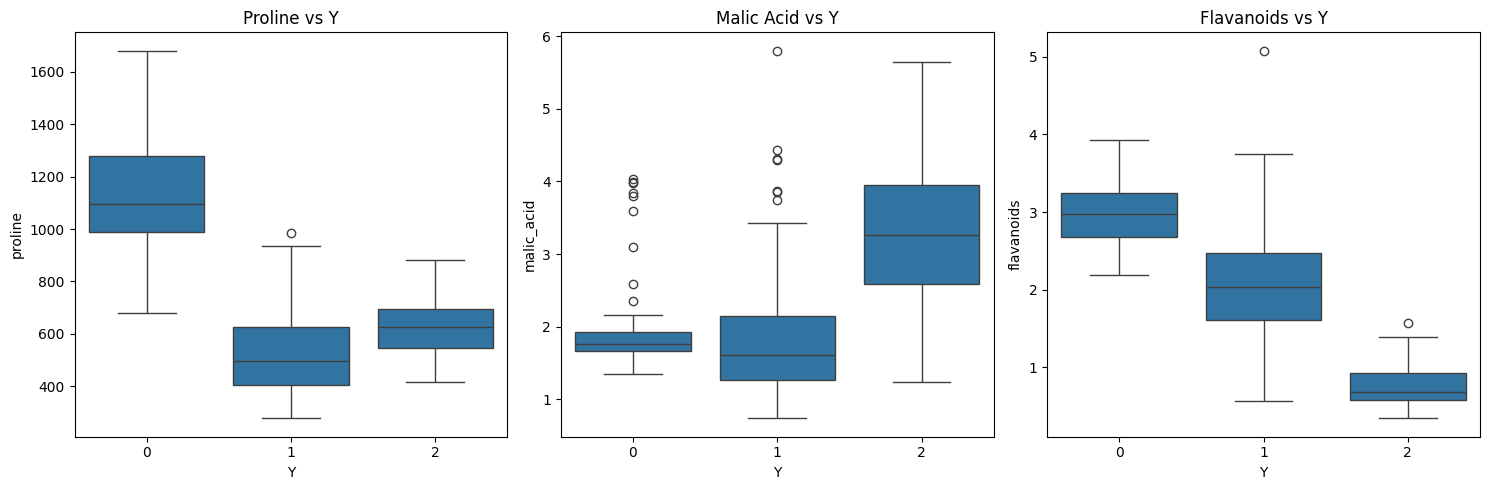

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(data=df, x='Y', y='proline', ax=axes[0])
sns.boxplot(data=df, x='Y', y='malic_acid', ax=axes[1])
sns.boxplot(data=df, x='Y', y='flavanoids', ax=axes[2])
axes[0].set_title('Proline vs Y')
axes[1].set_title('Malic Acid vs Y')
axes[2].set_title('Flavanoids vs Y')
plt.tight_layout()
plt.show()


Boxplot tersebut memperlihatkan distribusi Proline, Malic Acid, dan Flavonoids berdasarkan kategori Y (0, 1, 2). Terlihat bahwa wine dengan Y = 0 memiliki kadar Proline tertinggi, menunjukkan kualitas atau kematangan anggur yang lebih baik, sementara Y = 1 memiliki nilai paling rendah. Untuk Malic Acid, wine dengan Y = 2 cenderung memiliki kadar lebih tinggi, menandakan rasa yang lebih asam. Sementara itu, pada Flavonoids, wine Y = 0 menunjukkan kadar tertinggi yang menurun drastis pada Y = 2, mencerminkan perbedaan signifikan dalam komposisi senyawa fenolik antar tipe wine. Secara keseluruhan, ketiga variabel ini menunjukkan peran penting dalam membedakan karakteristik kimia masing-masing kelas wine.

# Generate Rules with PRISM

In [35]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')


........................................................................
Target: 0
........................................................................
proline = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 24 rows matching the rule 
   Coverage: the rule matches: 24 out of 32 rows for target value: '0'. This is:
      75.000% of total rows for target value: '0'
      24.000% of total rows in data

........................................................................
Target: 1
........................................................................
color_intensity = Low AND alcohol = Low
   Support:  the target has value: '1' for 100.000% of the 25 rows matching the rule 
   Coverage: the rule matches: 25 out of 42 rows for target value: '1'. This is:
      59.524% of total rows for target value: '1'
      25.000% of total rows in data

........................................................................
Target: 2
......................

# Bin Ranges Result

In [36]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.45,12.42,49
1,alcohol,1,12.42,13.40,62
2,alcohol,2,13.40,14.83,65
3,malic_acid,0,0.89,1.67,55
4,malic_acid,1,1.67,2.46,60
5,malic_acid,2,2.46,5.80,62
6,ash,0,1.70,2.25,50
7,ash,1,2.25,2.46,63
8,ash,2,2.46,3.23,64
9,alcalinity_of_ash,0,11.20,18.00,52


# Test on Y Pred

In [37]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(50).drop(columns=['Y']))
f1_score(df.tail(50)['Y'], y_pred, average=None)

array([0.69230769, 0.64      , 0.58333333])

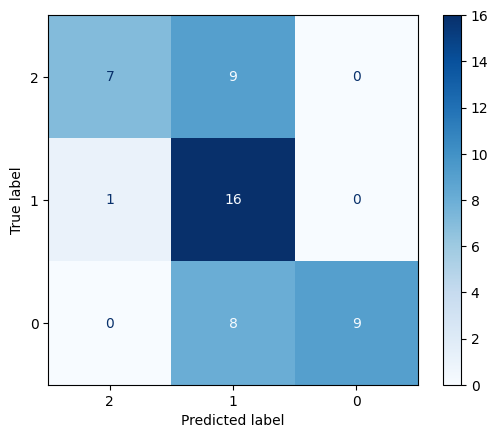

In [38]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(50)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

1. Which class is predicted best: Kelas 1 adalah yang diprediksi paling baik karena memiliki jumlah prediksi benar terbanyak (16) dan hanya sedikit kesalahan.
2. Are there misclassifications: Iya, terdapat beberapa misclassifications. Tterutama kelas 2 yang sering salah diprediksi sebagai kelas 1, serta kelas 0 yang juga kadang diprediksi sebagai kelas 1.

In [39]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(50)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69        17
           1       0.48      0.94      0.64        17
           2       0.88      0.44      0.58        16

    accuracy                           0.64        50
   macro avg       0.79      0.64      0.64        50
weighted avg       0.78      0.64      0.64        50



1. Which class is predicted best: Kelas 0 memiliki precision tertinggi (1.00), menunjukkan model sangat akurat saat memprediksi kelas ini, meskipun recall-nya rendah.
2. Are there misclassifications: Iya, terlihat dari recall yang rendah pada kelas 0 dan 2, banyak data dari kelas tersebut yang salah diklasifikasikan sebagai kelas lain. Secara keseluruhan, akurasi model masih sedang yaitu 64%, menunjukkan adanya ruang untuk perbaikan pada keseimbangan prediksi antar kelas.

In [41]:
# Create new data points for the Iris dataset
# You can change these values to test different scenarios
new_data = { 'alcohol': [14.0, 14.00], 'malic_acid': [2.0, 2.0], 'ash': [2.3, 2.2], 'alcalinity_of_ash': [19.0, 11.0], 'magnesium': [95.0, 95.0], 'total_phenols': [2.2, 2.5], 'flavanoids': [0.14, 0.5], 'nonflavanoid_phenols': [0.14, 0.5], 'proanthocyanins': [1.6, 1.5], 'color_intensity': [7.0, 6.0], 'hue': [0.7, 0.6], 'od280/od315_of_diluted_wines': [3.2, 3.0], 'proline': [550.0, 1400.0] } 

new_df = pd.DataFrame(new_data)

# Predict on the new Iris data using the prism model trained on Iris data
iris_prediction = prism.predict(new_df)
# Assign predictions to a new column in the DataFrame
new_df['Predicted Class'] = iris_prediction

# Display the new data and prediction
print("New Data Points:")
display(new_df)

New Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,0


Berdasarkan hasil prediksi model PRISM, data pertama diklasifikasikan ke dalam Class 1 karena aturan yang berlaku pada data tersebut menunjukkan bahwa kadar flavanoids yang rendah (0.14) dan intensitas warna yang tinggi (7.0) merupakan pola yang umum ditemukan pada kelas tersebut. PRISM mengenali kombinasi atribut ini sebagai karakteristik khas wine dengan warna lebih pekat namun kandungan senyawa flavonoid yang sedikit. Sementara itu, data kedua diprediksi sebagai Class 0 karena sesuai dengan aturan yang menunjukkan bahwa nilai flavanoids yang tinggi (0.50), kadar proline yang besar (1400.0), serta kadar alkohol yang kuat (14.0) merupakan ciri utama kelas ini. Dengan demikian, PRISM mengklasifikasikan kedua data tersebut berdasarkan kesesuaian pola nilai atributnya dengan aturan yang paling relevan dan memiliki tingkat keyakinan tertinggi pada masing-masing kelas.

That's all. Thank you. Gbu